# Problem 3: Forest fire

Cortez and Morais (2007) analysed the forest fire data from the Montesinho natural park, from the Tra ́s-os-Montes northeast region of Portugal. They collected several quantities, including:

- **X**: x-axis spatial coordinate (from 1 to 9) within the Montesinho park map;
- **Y**: y-axis spatial coordinate (from 2 to 9) within the Montesinho park map;
- **FFMC**: fine fuel moisture code;
- **DMC**: duff moisture code;
- **DC**: drought code;
- **ISI**: initial spread index;
- **temp**: temperature in Celsius degrees;
- **RH**: relative humidity in %;
- **wind**: wind speed in km/h;
- **rain**: outside rain in mm/m2;

The goal of this exercise is to create a model to predict the burned area of the forest, that Cortez and Morais (2007) suggested to logarithmically transform due to its skewness toward 0. The dataset already contains the transformed variable (logArea). Try some of the approaches seen in the course and provide a final model that can be used to predict the logarithm of the burned area. Describe your work and the reasons behind the choice of the final model.

## Setup

In [120]:
# install.packages('caret')
# install.packages('glmnet')
library(caret)

In [121]:
RMSE = function(model, data) {
  predictions = predict(model, data)
  prediction.error = sqrt(mean((predictions - data$logArea)^2))
  return(prediction.error)
}

In [122]:
AllColumnsExcept = function(data, col.names) {
    columns = !(names(data) %in% col.names)
    return(data[, columns])
}

## Load data

In [189]:
load("forestfires.rdata")

## Feature engineering

In [190]:
data$distanceFromCenter = sqrt((data$X - 5)^2 + (data$Y - 5)^2)

In [191]:
data$FFMC.squared = data$FFMC^2
data$FFMC.cube = data$FFMC^3
data$FFMC.inv = data$FFMC^(-1)
data$FFMC.log = log(data$FFMC)

data$DMC.squared = data$DMC^2
data$DMC.cube = data$DMC^3
data$DMC.inv = data$DMC^(-1)
data$DMC.log = log(data$DMC)

data$DC.squared = data$DC^2
data$DC.cube = data$DC^3
data$DC.inv = data$DC^(-1)
data$DC.log = log(data$DC)

data$ISI.squared = data$ISI^2
data$ISI.cube = data$ISI^3
data$ISI.inv = (data$ISI + 1)^(-1)
data$ISI.log = log(data$ISI + 1)

data$temp.squared = data$temp^2
data$temp.cube = data$temp^3
data$temp.inv = data$temp^(-1)
data$temp.log = log(data$temp)

data$RH.squared = data$RH^2
data$RH.cube = data$RH^3
data$RH.inv = data$RH^(-1)
data$RH.log = log(data$RH)

data$wind.squared = data$wind^2
data$wind.cube = data$wind^3
data$wind.inv = data$wind^(-1)
data$wind.log = log(data$wind)

data$rain.squared = data$rain^2
data$rain.cube = data$rain^3
data$rain.inv = (data$rain + 1)^(-1)
data$rain.log = log(data$rain + 1)

# Dummies
data$is.raining = data$rain > 0

In [192]:
# Interactions
interactions = as.data.frame(model.matrix(~(.)^2 - 1, AllColumnsExcept(data, 'logArea')))
interactions$logArea = data$logArea
data = interactions

## 1. Split data

[ESL:] The test set should be kept in a “vault,” and be brought out only at the end of the data analysis. If we use the test-set repeatedly, choosing the model with smallest test-set error, the test set error of the final chosen model will underestimate the true test error.

In [193]:
# Shuffle data
set.seed(4030)
data = data[sample(nrow(data)), ]
numOfObservations = nrow(data)
numOfObservations

[1] 517

In [194]:
# Make test set for assessing generalization error of the final chosen model
testIndices = 1:117
test.data = data[testIndices, ]
training.data = data[-testIndices, ]

In [195]:
sd(training.data$logArea)

[1] 1.390659

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

Boosted Generalized Linear Model 

400 samples
991 predictors

Pre-processing: centered (991) 
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 360, 360, 360, 360, 360, 360, ... 
Resampling results across tuning parameters:

  mstop  RMSE      Rsquared    MAE     
    1    1.380387  0.02857392  1.155018
   11    1.381080  0.02756981  1.152735
   21    1.379806  0.02716128  1.148896
   31    1.380530  0.02834931  1.147412
   41    1.382849  0.02832995  1.147167
   51    1.386785  0.02862264  1.149119
   61    1.392270  0.02862402  1.151574
   71    1.396490  0.02873803  1.152791
   81    1.401215  0.02904093  1.154267
   91    1.405917  0.02914713  1.155542
  101    1.410191  0.02876645  1.156525
  111    1.413431  0.02890775  1.157316
  121    1.416665  0.02851961  1.158289
  131    1.419837  0.02843952  1.159190
  141    1.422762  0.02830263  1.160098
  151    1.425020  0.02857758  1.160699

Tuning parameter 'prune' was held constant at a value of no


,mstop,prune
3,21,no


(Intercept)     `\\`X:wind.squared\\`` 
              3.750169e-18               2.237617e-04 
       `\\`Y:temp.cube\\``        `\\`DMC:ISI.inv\\`` 
              7.778603e-07               3.196087e-03 
`\\`ISI:is.rainingTRUE\\``       `\\`RH:temp.cube\\`` 
             -2.989368e-02               1.796153e-07 
`\\`temp.inv:wind.cube\\``   `\\`RH.cube:wind.inv\\`` 
              5.537760e-03              -1.949036e-07 
attr(,"offset")
[1] 1.136931

[1] 1.379806

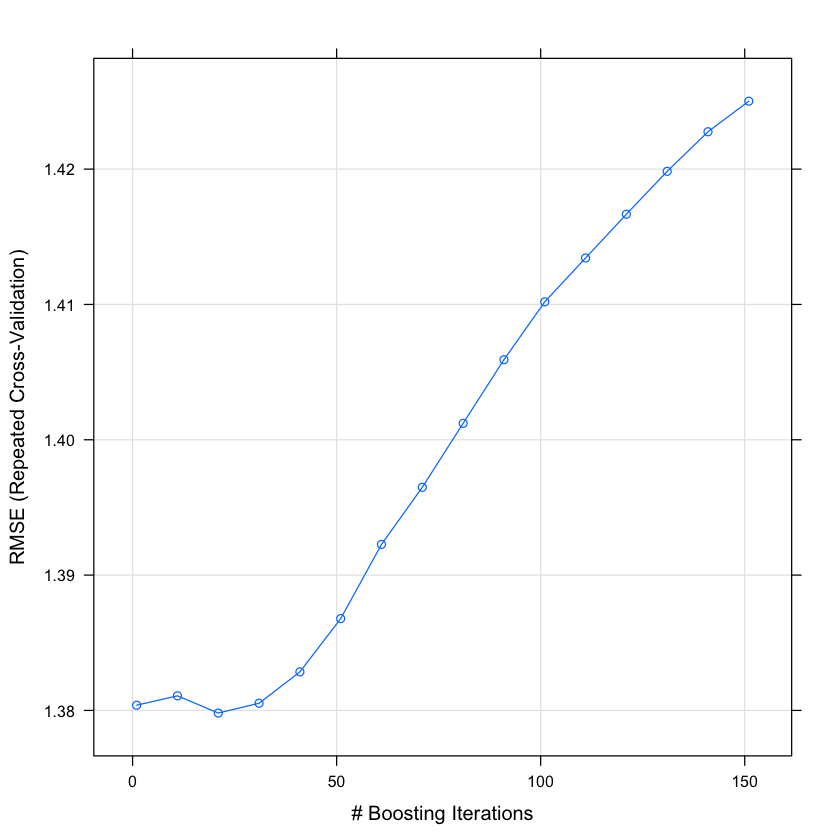

In [196]:
model = train(
    logArea ~ .,
    data = training.data,
    method = 'glmboost',
    family = Gaussian(),
    preProcess = "center",
    tuneGrid = expand.grid(
        mstop = seq(1, 151, 10),
        prune = "no"
    ),
    trControl = trainControl(
        method = 'repeatedcv',
        number = 10,
        repeats = 10
    )
)
model
model$bestTune
coef(model$finalModel, model$bestTune$lambda)
min(model$results$RMSE)
plot(model)

In [118]:
model = train(
    logArea ~ .,
    data = training.data,
    preProcess = "scale",
    method = 'pls',
    tuneGrid = expand.grid(ncomp = 1:30),
    trControl = trainControl(
        method = 'cv',
        number = 10
    )
)
model
model$bestTune
coef(model$finalModel, model$bestTune$lambda)
min(model$results$RMSE)

Partial Least Squares 

400 samples
991 predictors

Pre-processing: scaled (991) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 360, 360, 360, 360, 360, 360, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared    MAE     
   1      6.357897  0.06264612  1.978890
   2      2.160597  0.05215579  1.306719
   3      1.576831  0.06003344  1.194700
   4      3.424959  0.06575870  1.486477
   5      3.011230  0.04724322  1.440513
   6      5.192512  0.04971487  1.771524
   7      6.341241  0.05901656  1.971427
   8      3.542988  0.02881770  1.551094
   9      3.699575  0.03879435  1.564150
  10      3.526614  0.03423016  1.627882
  11      7.243802  0.03373921  2.258382
  12      9.836331  0.04378418  2.623884
  13      5.682570  0.03309006  2.041795
  14      3.349644  0.05408819  1.640527
  15     10.968459  0.06996914  2.788365
  16      8.163371  0.05300048  2.387926
  17      8.208135  0.03694491  2.463063
  18      9.877715  0.04794132  2.7

,ncomp
3,3


<991 x 1 x 0 array of double>
                                          .outcome
X                                        
Y                                        
FFMC                                     
DMC                                      
DC                                       
ISI                                      
temp                                     
RH                                       
wind                                     
rain                                     
distanceFromCenter                       
FFMC.squared                             
FFMC.cube                                
FFMC.inv                                 
FFMC.log                                 
DMC.squared                              
DMC.cube                                 
DMC.inv                                  
DMC.log                                  
DC.squared                               
DC.cube                                  
DC.inv                                   
DC.log                                   
ISI.squared                              
ISI.cube                                 
ISI.inv                                  
ISI.log                                  
temp.squared                             
temp.cube                                
temp.inv                                 
temp.log                                 
RH.squared                               
RH.cube                                  
RH.inv                                   
RH.log                                   
wind.squared                             
wind.cube                                
wind.inv                                 
wind.log                                 
rain.squared                             
rain.cube                                
rain.inv                                 
rain.log                                 
is.rainingFALSE                          
is.rainingTRUE                           
`\\`X:Y\\``                              
`\\`X:FFMC\\``                           
`\\`X:DMC\\``                            
`\\`X:DC\\``                             
`\\`X:ISI\\``                            
`\\`X:temp\\``                           
`\\`X:RH\\``                             
`\\`X:wind\\``                           
`\\`X:rain\\``                           
`\\`X:distanceFromCenter\\``             
`\\`X:FFMC.squared\\``                   
`\\`X:FFMC.cube\\``                      
`\\`X:FFMC.inv\\``                       
`\\`X:FFMC.log\\``                       
`\\`X:DMC.squared\\``                    
`\\`X:DMC.cube\\``                       
`\\`X:DMC.inv\\``                        
`\\`X:DMC.log\\``                        
`\\`X:DC.squared\\``                     
`\\`X:DC.cube\\``                        
`\\`X:DC.inv\\``                         
`\\`X:DC.log\\``                         
`\\`X:ISI.squared\\``                    
`\\`X:ISI.cube\\``                       
`\\`X:ISI.inv\\``                        
`\\`X:ISI.log\\``                        
`\\`X:temp.squared\\``                   
`\\`X:temp.cube\\``                      
`\\`X:temp.inv\\``                       
`\\`X:temp.log\\``                       
`\\`X:RH.squared\\``                     
`\\`X:RH.cube\\``                        
`\\`X:RH.inv\\``                         
`\\`X:RH.log\\``                         
`\\`X:wind.squared\\``                   
`\\`X:wind.cube\\``                      
`\\`X:wind.inv\\``                       
`\\`X:wind.log\\``                       
`\\`X:rain.squared\\``                   
`\\`X:rain.cube\\``                      
`\\`X:rain.inv\\``                       
`\\`X:rain.log\\``                       
`\\`X:is.rainingTRUE\\``                 
`\\`Y:FFMC\\``                           
`\\`Y:DMC\\``                            
`\\`Y:DC\\``                             
`\\`Y:ISI\\``                            
`\\`Y:temp\\``                           
`\\`Y:RH\\`` 

[1] 1.576831

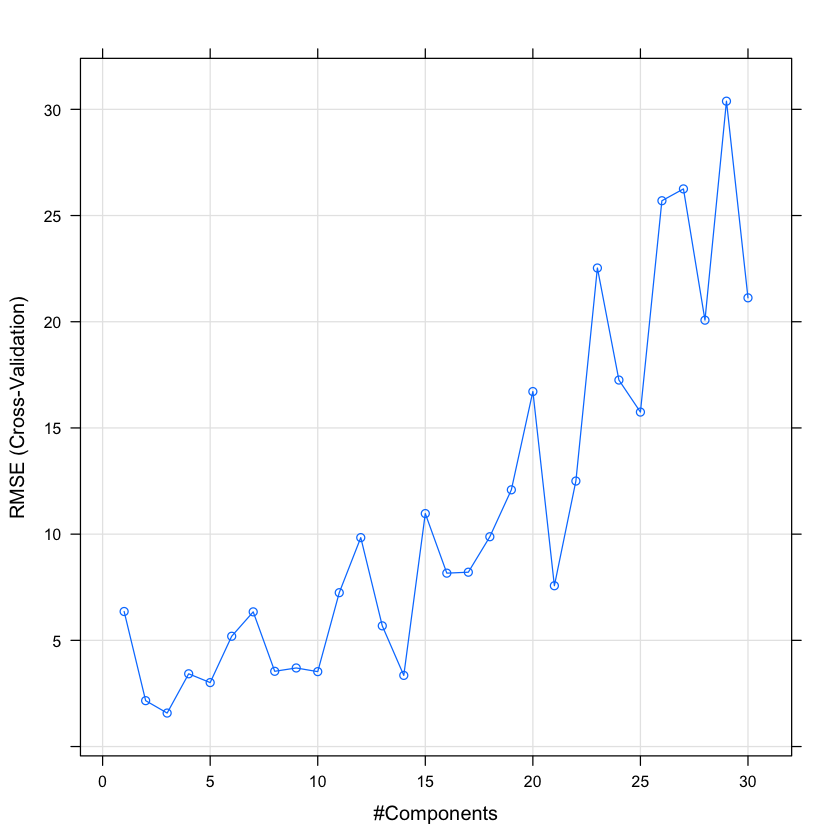

In [119]:
plot(model)

In [112]:
model = train(
    logArea ~ temp + wind + rain + RH,
    data = training.data,
    preProcess = "scale",
    method = 'pcr',
    tuneGrid = expand.grid(ncomp = 1:4),
    trControl = trainControl(
        method = 'cv',
        number = 10
    )
)
model
model$bestTune
coef(model$finalModel, model$bestTune$lambda)
min(model$results$RMSE)

Principal Component Analysis 

400 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 360, 360, 360, 360, 360, 360, ... 
Resampling results across tuning parameters:

  ncomp  RMSE      Rsquared    MAE     
  1      1.406129  0.03348942  1.173215
  2      1.409733  0.02611265  1.177880
  3      1.402292  0.02972042  1.167139
  4      1.481296  0.02395406  1.191396

RMSE was used to select the optimal model using  the smallest value.
The final value used for the model was ncomp = 3.

,ncomp
3,3


<4 x 1 x 0 array of double>
     .outcome
temp
wind
rain
RH

[1] 1.402292

In [142]:
model = train(
    logArea ~ .,
    data = training.data,
    preProcess = "scale",
    method = 'glmnet',
    tuneGrid = expand.grid(
        alpha = 1,
        lambda = seq(0, 1, 0.1)
    ),
    trControl = trainControl(
        method = 'cv',
        number = 10
    )
)
model
model$bestTune
coef(model$finalModel, model$bestTune$lambda)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

glmnet 

400 samples
 44 predictor

Pre-processing: scaled (44) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 360, 360, 360, 360, 360, 360, ... 
Resampling results across tuning parameters:

  lambda  RMSE      Rsquared    MAE     
  0.0     3.779727  0.01009565  1.585397
  0.1     1.412364  0.02259800  1.167288
  0.2     1.407744         NaN  1.162238
  0.3     1.407744         NaN  1.162238
  0.4     1.407744         NaN  1.162238
  0.5     1.407744         NaN  1.162238
  0.6     1.407744         NaN  1.162238
  0.7     1.407744         NaN  1.162238
  0.8     1.407744         NaN  1.162238
  0.9     1.407744         NaN  1.162238
  1.0     1.407744         NaN  1.162238

Tuning parameter 'alpha' was held constant at a value of 1
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were alpha = 1 and lambda = 1.

,alpha,lambda
11,1,1


45 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)        1.121441
X                  .       
Y                  .       
FFMC               .       
DMC                .       
DC                 .       
ISI                .       
temp               .       
RH                 .       
wind               .       
rain               .       
distanceFromCenter .       
FFMC.squared       .       
FFMC.cube          .       
FFMC.inv           .       
FFMC.log           .       
DMC.squared        .       
DMC.cube           .       
DMC.inv            .       
DMC.log            .       
DC.squared         .       
DC.cube            .       
DC.inv             .       
DC.log             .       
ISI.squared        .       
ISI.cube           .       
ISI.inv            .       
ISI.log            .       
temp.squared       .       
temp.cube          .       
temp.inv           .       
temp.log           .       
RH.squared         .       
RH.cub

In [143]:
min(model$results$RMSE)

[1] 1.407744

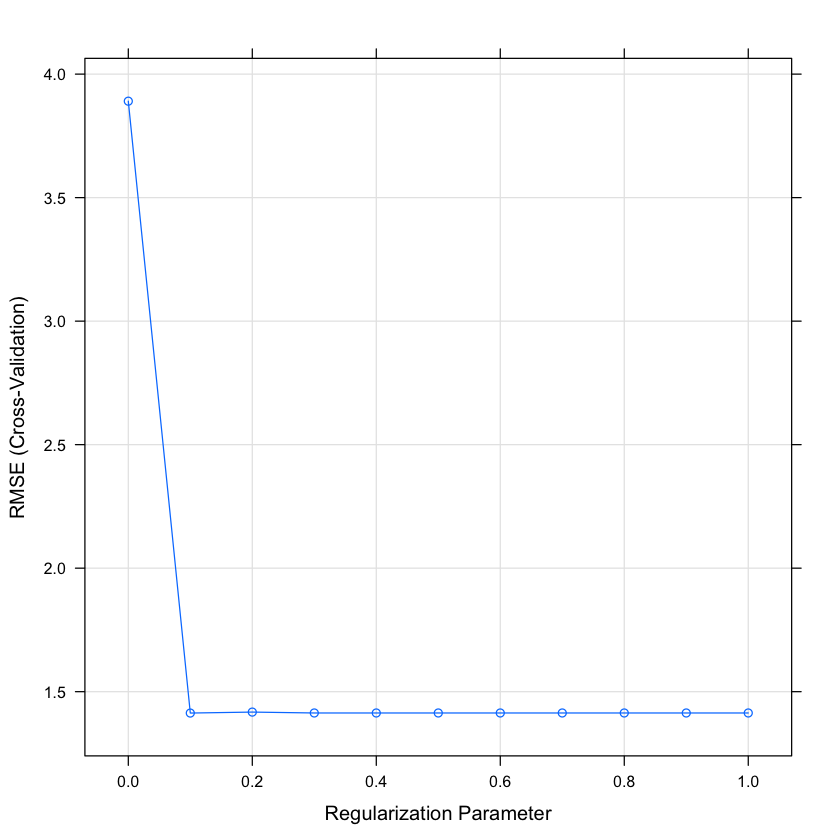

In [103]:
plot(model)

In [46]:
model = train(
    logArea ~ .,
    data = training.data,
    preProcess = "scale",
    method = 'glmnet',
    tuneGrid = expand.grid(
        alpha = 1,
        lambda = 1:2
    ),
    trControl = trainControl(
        method = 'cv',
        number = 2
    )
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

In [ ]:
as.matrix(coef(model$finalModel, model$bestTune$lambda))

In [103]:
model = train(
    logArea ~ .,
    data = training.data,
    preProcess = "scale",
    method = 'glmnet',
    tuneLength = 50
)
model

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

glmnet 

400 samples
 24 predictor

Pre-processing: scaled (24) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 400, 400, 400, 400, 400, 400, ... 
Resampling results across tuning parameters:

  alpha      lambda        RMSE      Rsquared     MAE     
  0.1000000  3.878998e-05  8.116211  0.010685722  1.728619
  0.1000000  4.646768e-05  8.116211  0.010685722  1.728619
  0.1000000  5.566502e-05  8.116211  0.010685722  1.728619
  0.1000000  6.668278e-05  8.116211  0.010685722  1.728619
  0.1000000  7.988129e-05  8.116211  0.010685722  1.728619
  0.1000000  9.569218e-05  8.116211  0.010685722  1.728619
  0.1000000  1.146325e-04  8.116211  0.010685722  1.728619
  0.1000000  1.373217e-04  8.116211  0.010685722  1.728619
  0.1000000  1.645018e-04  8.114559  0.010699012  1.728458
  0.1000000  1.970616e-04  8.104028  0.010699034  1.727369
  0.1000000  2.360659e-04  8.088502  0.010720721  1.725926
  0.1000000  2.827904e-04  8.060721  0.010757595  1.723152
  0.1000000  3.387631e-04 

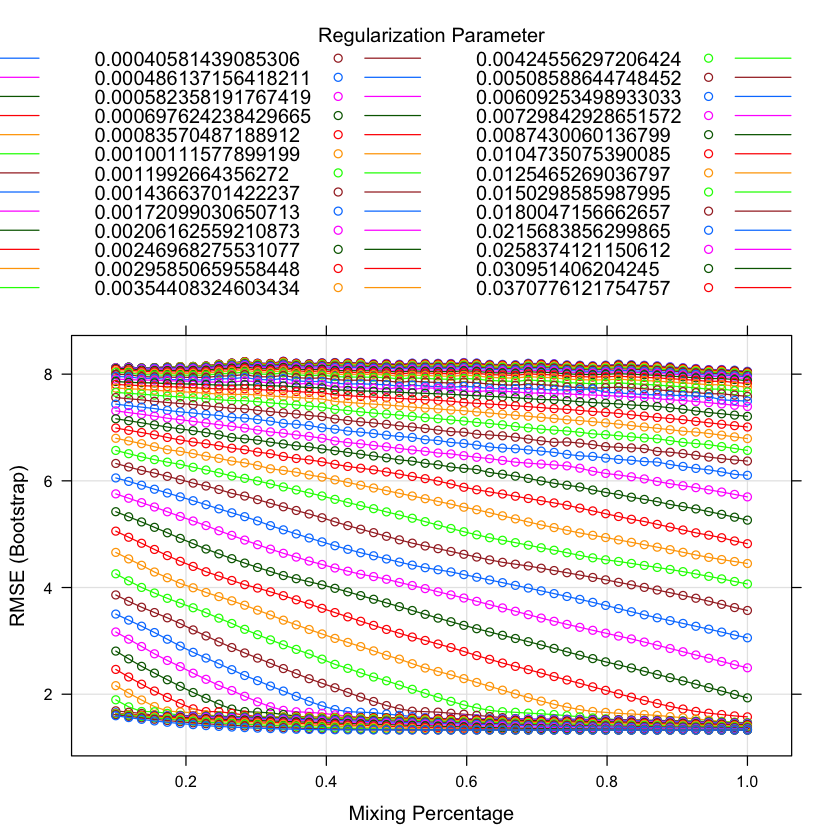

In [104]:
plot(model)